In [24]:
ENV["GKS_ENCODING"] = "utf-8"
using NLsolve
using Plots
using BenchmarkTools
using Distributed
using IntervalArithmetic, IntervalRootFinding

include("/home/julian/Hamburg/LadderDGA/run.jl");

using 8 workers.


 Activating environment at `~/Hamburg/LadderDGA/Project.toml`


      From worker 5:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 2:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 8:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 7:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 3:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 6:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 4:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 2:	WARNING: replacing module LadderDGA.
      From worker 4:	WARNING: replacing module LadderDGA.
      From worker 3:	WARNING: replacing module LadderDGA.
      From worker 5:	WARNING: replacing module LadderDGA.
      From worker 8:	WARNING: replacing module LadderDGA.
      From worker 6:	WARNING: replacing module LadderDGA.
      From worker 7:	WARNING: replacing module LadderDGA.


┌ Warning: ArgParse not working with jupyter notebooks
└ @ Main.LadderDGA ~/Hamburg/LadderDGA/src/DepsInit.jl:48
┌ Warning: Check U and Beta consistency in chi_dir/gamma_dir
└ @ Main.LadderDGA ~/Hamburg/LadderDGA/src/DepsInit.jl:49
[ Info: Reading Inputs...
[ Info: Reading Fortran Input, this can take several minutes.
[ Info: Done Reading Gamma
[ Info: Done Reading chi
┌ Info: loading from 
└   env.inputVars = "vars.jld"
┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ Main.LadderDGA ~/Hamburg/LadderDGA/src/helpers.jl:77
┌ Info: Inputs Read. Starting Computation.
│ Found usable intervals for local susceptibility of length 
│       sp: 35
│       ch: 33 
└       χLoc_sp = 0.345, χLoc_ch = 0.1601
┌ Warning: Forcing non tail corrected summation in EoM
└ @ Main.LadderDGA ~/Hamburg/LadderDGA/src/DepsInit.jl:101
[ Info: Calculating local quantities: 
[ Info: Calculating bubble: 
[ Info: Calculating χ and γ: 
[ Info: Calculating λ correction in the spin cha

[ Info: Done.


In [2]:
modelParams, simParams, env, impQ_sp, impQ_ch, GImp_pos, Σ_loc_pos, FUpDo  = LadderDGA.setup_LDGA("config.toml", false);
mP = LadderDGA.modelParams;
sP = LadderDGA.simParams;
qMultiplicity = LadderDGA.qMultiplicity;
function subtract_tail(inp, Ekin, mP)
    res = zeros(eltype(inp), size(inp)...)
    iωₙ2_full  = zeros(length(inp))
    for i in 1:length(inp)
        iωₙ2_full[i] = (LadderDGA.iω(i - ceil(Int64, length(inp)/2) - 0))^2
    end
    for n in 1:length(inp)
        if iωₙ2_full[n] != 0
            res[n] = inp[n] - (Ekin/iωₙ2_full[n])
        else
            res[n] = inp[n]
        end
    end
    return res
end

function subtract_tail!(inp, Ekin, mP)
    iωₙ2_full  = zeros(length(inp))
    for i in 1:length(inp)
        iωₙ2_full[i] = (LadderDGA.iω(i - ceil(Int64, length(inp)/2) - 0))^2
    end
    for n in 1:length(inp)
        if iωₙ2_full[n] != 0
            inp[n] -= (Ekin/iωₙ2_full[n])
        end
    end
end

[ Info: Reading Fortran Input, this can take several minutes.
[ Info: Done Reading Gamma
[ Info: Done Reading chi
┌ Info: loading from 
└   env.inputVars = "vars.jld"
┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ Main.LadderDGA ~/Hamburg/LadderDGA/src/helpers.jl:77


subtract_tail! (generic function with 1 method)

In [3]:
tc = false
usable_ω = intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω);
rχsp = real.(nlQ_sp.χ[usable_ω,:]);
rχch = real.(nlQ_ch.χ[usable_ω,:]);
rhs_val = tc ? (mP.n) * (1 - mP.n/2) : real(impQ_sp.χ_loc + impQ_ch.χ_loc)

χ_λ(χ, λ) = map(χi -> 1.0 / ((1.0 / χi) + λ), χ)
nc = [0,1,2,3]
NW = floor(Int64, size(rχch, 1)/2)
ωmin = Int(floor(NW*1/4))
ωmax = NW 
W = LadderDGA.build_weights(ωmin, ωmax, [0,1,2,3])

iνₙ, GImp_pos    = LadderDGA.readGImp(LadderDGA.env.inputDir * "/gm_wim", only_positive=true)
ϵₖ, Vₖ, μ    = LadderDGA.read_anderson_parameters(LadderDGA.env.inputDir * "/hubb.andpar");
E_kin_ED, E_pot_ED  = LadderDGA.calc_E_ED(iνₙ[1:5000], ϵₖ, Vₖ, GImp_pos[1:5000], mP)
rem_full = -E_kin_ED*(mP.β*mP.β)/12

function construct_f!(F, λ, rhs)#default rhs χLocsp + χLocch or n/2 (1-n/2)
    χsp_λ = χ_λ(rχ_sp, λ[1])
    χch_λ = χ_λ(rχ_ch, λ[2]) 
    χupup = LadderDGA.sum_q(χch_λ .+ χsp_λ, qMultiplicity, dims=2)[:,1]
    #, [1], tc, mP.β, weights=W)[1]  
    tmp =  (sum(subtract_tail(χupup, E_kin_ED, mP))+rem_full)/mP.β        
    F[1] = real(tmp - rhs)
end


function construct_f(λsp, λch, χsp, χch; mode=:naive, rhs=rhs_val) 
    χsp_λ = LadderDGA.χ_λ(χsp, λsp)
    χch_λ = LadderDGA.χ_λ(χch, λch)
    χupup = LadderDGA.sum_q(χch_λ .+ χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1]
    tmp = 0.0
    #println("eval λsp = $λsp, λch = $λch")
    if mode == :naive
        tmp = real(sum(χupup)/mP.β - rhs)
    elseif mode == :sub
        tmp =  real((sum(subtract_tail(χupup, E_kin_ED, mP)) + rem_full)/mP.β - rhs)
    elseif mode == :fit
        tmp =  real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=W)[1] - rhs)        
    else
        tmp =  real(LadderDGA.sum_freq(subtract_tail(χupup, E_kin_ED, mP), [1], true, mP.β, correction=rem_full, weights=W)[1]- rhs)
    end 
    return tmp
end

function construct_df(λsp, λch, χsp, χch; mode=:naive, rhs=rhs_val) 
    χsp_λ = LadderDGA.dχ_λ(χsp, λsp)
    χch_λ = LadderDGA.dχ_λ(χch, λch)
    χupup = LadderDGA.sum_q(χch_λ .+ χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1]
    tmp = 0.0
    #println("eval λsp = $λsp, λch = $λch")
    if mode == :naive
        tmp = real(sum(χupup)/mP.β)
    elseif mode == :sub
        tmp =  real((sum(subtract_tail(χupup, E_kin_ED, mP)) + rem_full)/mP.β)
    elseif mode == :fit
        tmp =  real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=W)[1])        
    else
        tmp =  real(LadderDGA.sum_freq(subtract_tail(χupup, E_kin_ED, mP), [1], true, mP.β, correction=rem_full, weights=W)[1])
    end 
    return tmp
end

construct_df (generic function with 1 method)

# Condition 1

In [9]:
testf(λsp) = construct_f(λsp, 0.0, rχsp, rχch, mode=:fit, rhs=rhs_val)
testdf(λsp) = construct_df(λsp, 0.0, rχsp, rχch, mode=:fit, rhs=rhs_val)
Xsp = @interval(0.02, 0.1)
@time res_roots = roots(testf, testdf, Xsp, Newton, 1e-8)
max_int = maximum(filter(x->!isempty(x),interval.(res_roots)))

 11.910771 seconds (87.64 M allocations: 2.883 GiB, 5.01% gc time)


[0.0495442, 0.0495443]

## compute λsp(λch) (NLsolve)

101 of 101

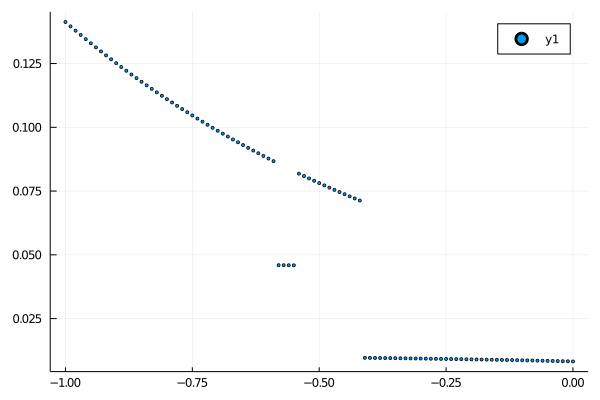

In [17]:
λch_range = -1.0:0.01:0.0
spOfch_max_nl = zeros(size(λch_range))
for (λi,λchi) in enumerate(λch_range)
    testf!(F,λ) = F[1]=construct_f(λ[1], λchi, rχsp, rχch, mode=:fit, rhs=rhs_val)
    res = nlsolve(testf!, [0.8])
    spOfch_max_nl[λi] = res.zero[1]
    print("\r$λi of $(length(λch_range))")
end
plot(λch_range,spOfch_max_nl, seriestype=:scatter, markersize=1.8)

In [18]:
spOfch_max_nl

101-element Array{Float64,1}:
 0.14128572536867992
 0.13956835719381727
 0.13787501936974955
 0.13620525433117528
 0.13455861692970364
 0.13293467404480144
 0.13133300421024136
 0.12975319725630313
 0.12819485396649422
 0.12665758574827696
 0.12514101431740604
 0.12364477139536534
 0.12216849841889516
 ⋮
 0.008686912340621264
 0.00864704890472512
 0.0086065081644637
 0.008565277077085145
 0.008523342455414288
 0.008480690949586199
 0.00843730910635591
 0.008393183338118395
 0.008348299950163457
 0.008302645153371778
 0.008256205078626436
 0.008208965792719828

## compute λsp(λch) (Roots)

In [6]:
Xsp = @interval(0.02,0.5)
Xch = @interval(-2,2)
λch_range_c1 = -3.0:0.1:1.0
λch_range2_c1 = -15:1.0:15
spOfch_max_int_c1 = zeros(4,size(λch_range_c1)...)
spOfch_max_int_c1 = zeros(4,size(λch_range_c1)...)
spOfch2_max_int_c1 = zeros(4,size(λch_range2_c1)...)
spOfch3_max_int_c1 = zeros(4,size(λch_range2_c1)...);

In [7]:
testf(λsp) = construct_f(λsp, 0.0, rχsp, rχch, mode=:fit, rhs=rhs_val)
testdf(λsp) = construct_df(λsp, 0.0, rχsp, rχch, mode=:fit, rhs=rhs_val)
for (mi,m) in enumerate([:naive, :fit])
    println("\rmode: ", m)
    rhs_val = (m == :fit) ? (mP.n) * (1 - mP.n/2) : real(impQ_sp.χ_loc + impQ_ch.χ_loc)
    for (λi,λchi) in enumerate(λch_range_c1)
        print("\r", λi, " of ", length(λch_range_c1))
        testf(λsp) = construct_f(λsp, λchi, rχsp, rχch, mode=m, rhs=rhs_val)
        res_internal = roots(testf, testdf, Xsp, Newton, 1e-6)
        max_int = maximum(interval.(res_internal))
        spOfch_max_int_c1[mi,λi] = mid(max_int)
    end
end
#for (mi,m) in enumerate([:naive, :sub, :fit, :both])
#    println("\rmode: ", m)
#    for (λi,λchi) in enumerate(λch_range2_c1)
#        testf(λsp) = construct_f(λsp, λchi, rχsp, rχch, mode=m, rhs=rhs_val)
#        res_internal = roots(testf, testdf, Xsp, Newton, 1e-5)
#        max_int = maximum(interval.(res_internal))
#        spOfch2_max_int_c1[mi,λi] = mid(max_int)
#        print("\r", rpad(λi,length(string(length(λch_range2_c1)))), " of ", length(λch_range2_c1))
#    end
#end

#for (λi,λchi) in enumerate(λch_range2_c1)
#    testf(λsp) = construct_f(λsp, λchi, rχsp, rχch, qMultiplicity, rhs=rhs)
#    res_internal = roots(testf, Xsp, Newton, 1e-5)
#    max_int = maximum(interval.(res_internal))
#    spOfch3_max_int_c1[λi] = mid(max_int)
#    print("\r", λi, " of ", length(λch_range2_c1))
#end

mode: naive
mode: 41fit
41 of 41

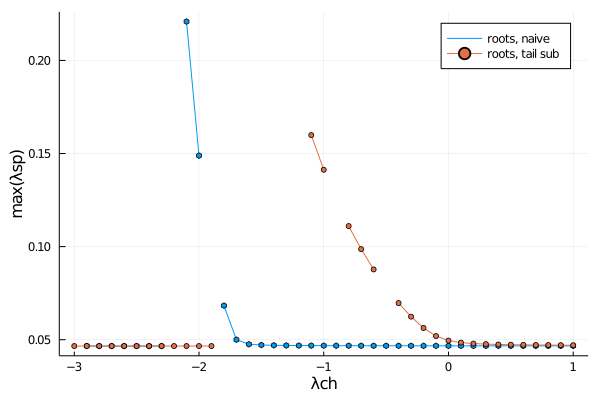

In [8]:
plot(λch_range_c1[1:end], spOfch_max_int_c1[1,1:end], label="roots, naive", xlabel="λch", ylabel="max(λsp)", xticks = λch_range_c1[1:10:end], markershape=:hexagon, markersize=2.8)
plot!(λch_range_c1[1:end], spOfch_max_int_c1[2,1:end], label="roots, tail sub", xlabel="λch", ylabel="max(λsp)", xticks = λch_range_c1[1:10:end], markershape=:circle, markersize=2.8)
#plot!(λch_range2_c1[10:end], spOfch2_max_int_c1[3,10:end], label="roots, fit", xlabel="λch", ylabel="max(λsp)", xticks = λch_range2_c1[1:10:end],seriestype = :scatter, markersize=2.8)
#plot!(λch_range2_c1[10:end], spOfch2_max_int_c1[4,10:end], label="roots, both", xlabel="λch", ylabel="max(λsp)", xticks = λch_range2_c1[1:10:end],seriestype = :scatter, markersize=2.8)
#savefig("roots_tc_EoMtc.pdf")
#plot!(λch_range, spOfch_max_nl, label="NLsolve", seriestype = :scatter, markersize=0.8)

In [22]:
#using JLD
#save("cond_1_data_b25u1_large_2.jld", "λch_range_c1", λch_range_c1, "spOfch_max_int_c1", spOfch_max_int_c1, "λch_range2_c1", λch_range2_c1, "spOfch2_max_int_c1", spOfch2_max_int_c1)

# Condition 2

In [59]:
function cond_Epot2(λsp, λch, nlQ_sp, nlQ_ch; rhs)
    #println("///1")
    usable_ω = intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)
    χsp_λ = χ_λ(nlQ_sp.χ, λsp)
    χch_λ = χ_λ(nlQ_ch.χ, λch)
    #println("///1.1")
    nlQ_sp_λ = LadderDGA.NonLocalQuantities_Interval(χsp_λ, nlQ_sp.γ, nlQ_sp.usable_ω, λsp)
    nlQ_ch_λ = LadderDGA.NonLocalQuantities_Interval(χch_λ, nlQ_ch.γ, nlQ_ch.usable_ω, λch)
    #println("///2")
    Σ_ladder = LadderDGA.calc_Σ(nlQ_sp_λ, nlQ_ch_λ, bubble, LadderDGA.GLoc_fft, 
                       LadderDGA.qIndices, usable_ω, sP.Nk)
    println("///3")
    Σ_ladder_corrected = Σ_ladder .- Σ_ladderLoc .+ Σ_loc_pos[eachindex(Σ_ladderLoc)]
    mP.U * sum(real.(χch_λ[usable_ω,:] .- χsp_λ[usable_ω,:])) ./ (mP.β*(sP.Nk^mP.D)) - rhs
end


function cond_Epot2_overview2(λsp, λch, nlQ_sp, nlQ_ch; rhs)
    χsp_λ = SharedArray(χ_λ(nlQ_sp.χ, λsp))
    χch_λ = SharedArray(χ_λ(nlQ_ch.χ, λch))
    usable_ω = intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)
    nlQ_sp_λ = LadderDGA.NonLocalQuantities(χsp_λ, nlQ_sp.γ, usable_ω, λsp)
    nlQ_ch_λ = LadderDGA.NonLocalQuantities(χch_λ, nlQ_ch.γ, usable_ω, λch)
    println("///3.1")
    Σ_ladder = LadderDGA.calc_Σ(nlQ_sp_λ, nlQ_ch_λ, bubble, LadderDGA.GLoc_fft, 
                       LadderDGA.qIndices, usable_ω, 1:sP.n_iν, sP.Nk)
    println("///3.3")
    Σ_ladder_corrected = Σ_ladder .- Σ_ladderLoc .+ LadderDGA.Σ_loc_pos[eachindex(Σ_ladderLoc)]
    #Σ_ladder_corrected, Σ_ladderLoc
    println("res = ", mP.U * sum(real.(χch_λ[usable_ω,:] .- χsp_λ[usable_ω,:])) ./ (mP.β*(sP.Nk^mP.D)))
    E_Kin, E_Pot = LadderDGA.calc_E(Σ_ladder_corrected, LadderDGA.ϵqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP)
    GC.gc()
    println("using ", nprocs(), " workers.")
    return [mP.U * sum(real.(χch_λ[usable_ω,:] .- χsp_λ[usable_ω,:])) ./ (mP.β*(sP.Nk^mP.D));E_Pot]
end

function cond_Epot_overview3(λsp, λch, nlQ_sp, nlQ_ch)
    res_roots, Σ_ladder2, lhs, E_pot = LadderDGA.calc_E_pot_cond(λsp, λch, nlQ_sp, nlQ_ch, bubble, 
                         LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                         LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                         LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                         mP, sP, sP.tail_corrected, find_root=false);
    return lhs, E_pot
end

cond_Epot_overview3 (generic function with 1 method)

In [6]:
λch_range_c2 = -1.0:0.3:1.0
#λch_range2_c2 = -20:0.5:20
#λch_range = -4.0:0.5:4.0
λsp_range_c2 = 0.0:0.09:0.6
#λch_range = -4.0:0.05:4.0
#λsp_range = 0.022:0.00001:0.023
rhs_overview_coarse = Array{Float64,2}(undef, length(λch_range_c2),length(λsp_range_c2));
lhs_overview_coarse = Array{Float64,2}(undef, length(λch_range_c2),length(λsp_range_c2));


overview_f(λsp, λch) = LadderDGA.cond_Epot2_overview(λsp, λch, nlQ_sp, nlQ_ch,rhs=E_pot_ED)
for i in (1:length(λch_range_c2))
    λch_i = λch_range_c2[i]
    for (j,λsp_i) in enumerate(λsp_range_c2)
        lhs, E_pot = cond_Epot_overview3(λsp_i, λch_i, nlQ_sp, nlQ_ch)
        lhs_overview_coarse[i,j] = lhs
        rhs_overview_coarse[i,j] = E_pot
        print("\r", rpad(i,3), " ", rpad(j,3), " = ", rpad((i-1)*length(λsp_range_c2) + j,4)," of ", length(λch_range_c2)*length(λsp_range_c2))   
    end
end

7   7   = 49   of 49

In [61]:
println(minimum(abs.(lhs_overview_coarse .- rhs_overview_coarse ./ 2)))
plot(heatmap(λch_range_c2, λsp_range_c2, abs.(lhs_overview .- rhs_overview), xlabel="λch", ylabel="λsp", title="|lhs-rhs|"), 
    heatmap(λch_range_c2, λsp_range_c2, rhs_overview, xlabel="λch", ylabel="λsp", title="rhs (EPot)"), 
    heatmap(λch_range_c2, λsp_range_c2, lhs_overview, xlabel="λch", ylabel="λsp", title="lhs"),
    plot(λch_range_c1[1:end], spOfch_max_int_c1[2,1:end], label="roots, fit", xlabel="λch", ylabel="max(λsp)", xticks = λch_range_c1[1:10:end], markershape=:hexagon, markersize=2.8),
    layout=(2,2),size=(900,800))
#writedlm("cond2.csv",  lhs_overview .- rhs_overview, ' ')

LoadError: UndefVarError: rhs_overview_coarse not defined

In [78]:
println(minimum(abs.(lhs_overview_coarse .* 2 .+ rhs_overview_coarse)))
plot(heatmap(λch_range_c2, λsp_range_c2, abs.(lhs_overview_coarse  .* 2 .+ rhs_overview_coarse ), xlabel="λch", ylabel="λsp", title="|lhs-rhs|"), 
    heatmap(λch_range_c2, λsp_range_c2, rhs_overview_coarse, xlabel="λch", ylabel="λsp", title="rhs (EPot)"), 
    heatmap(λch_range_c2, λsp_range_c2, lhs_overview_coarse, xlabel="λch", ylabel="λsp", title="lhs"),
    plot(λch_range_c1[1:end], spOfch_max_int_c1[2,1:end], label="roots, fit", xlabel="λch", ylabel="max(λsp)", xticks = λch_range_c1[1:10:end], markershape=:hexagon, markersize=2.8),
    layout=(2,2),size=(900,800))
#writedlm("cond2_rhs_2.csv",  round.(rhs_overview , digits=8), '\t')
#savefig("lhs_rhs.pdf")

0.00013040636244882053


In [25]:
λch_range_c2 = -1.0:0.05:1.0
#λch_range2_c2 = -20:0.5:20
#λch_range = -4.0:0.5:4.0
λsp_range_c2 = 0.045:0.001:0.12
#λch_range = -4.0:0.05:4.0
#λsp_range = 0.022:0.00001:0.023
rhs_overview = Array{Float64,2}(undef, length(λch_range_c2),length(λsp_range_c2));
lhs_overview = Array{Float64,2}(undef, length(λch_range_c2),length(λsp_range_c2));


overview_f(λsp, λch) = LadderDGA.cond_Epot2_overview(λsp, λch, nlQ_sp, nlQ_ch,rhs=E_pot_ED)
for i in (1:length(λch_range_c2))
    λch_i = λch_range_c2[i]
    for (j,λsp_i) in enumerate(λsp_range_c2)
        lhs, E_pot = cond_Epot_overview3(λsp_i, λch_i, nlQ_sp, nlQ_ch)
        lhs_overview[i,j] = lhs
        rhs_overview[i,j] = E_pot
        print("\r", rpad(i,3), " ", rpad(j,3), " = ", rpad((i-1)*length(λsp_range_c2) + j,4)," of ", length(λch_range_c2)*length(λsp_range_c2))   
    end
end

41  76  = 3116 of 3116 29  = 941  of 3116 = 1655 of 3116 34  = 1706 of 3116 6   = 2134 of 3116 24  = 2152 of 3116 = 2207 of 3116

In [ ]:
save("rhs_lhs_tc_EoMtc_b25u1_overview_2.jld", "lhs", lhs_overview, "rhs", rhs_overview, "λch_range_c2", λch_range_c2, "λsp_range_c2", λsp_range_c2)

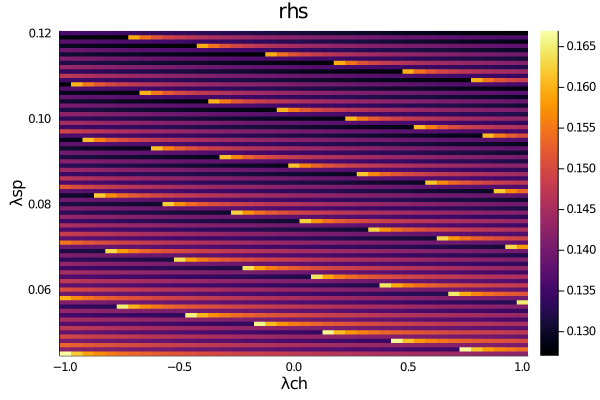

In [33]:
heatmap(λch_range_c2, λsp_range_c2, rhs_overview, xlabel="λch", ylabel="λsp", title="rhs")
#savefig("rhs_tc.pdf")

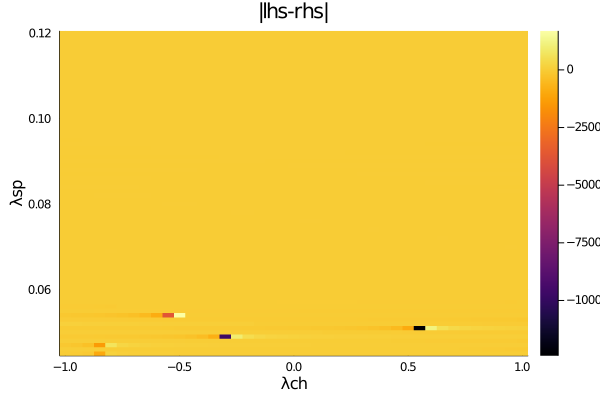

In [49]:
heatmap(λch_range_c2, λsp_range_c2, 1 ./ (lhs_overview .+ rhs_overview), xlabel="λch", ylabel="λsp", title="|lhs-rhs|")
#savefig("lhs_rhs_EoM_tc.pdf")

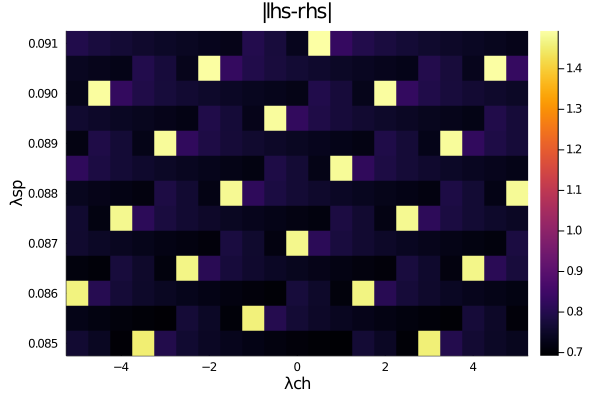

In [36]:
heatmap(λch_range_c2, λsp_range_c2, abs.(lhs_overview .- rhs_overview), xlabel="λch", ylabel="λsp", title="|lhs-rhs|")
#writedlm("cond2.csv",  lhs_overview .- rhs_overview, ' ')

# Both conditions

In [26]:
mP = LadderDGA.modelParams
sP = LadderDGA.simParams
using NLsolve
rrr = LadderDGA.extendend_λ(nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.1, -0.8]
 * Zero: [0.11746529679202022, -0.8417667179236025]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4

In [27]:
Wω   = LadderDGA.build_weights(1, floor(Int64, length(usable_ω)/2), [0,1,2,3,4])

res = rrr

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.1, -0.8]
 * Zero: [0.11746529679202022, -0.8417667179236025]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4

In [419]:
nc = [0,1,2,3]
NW = floor(Int64, length(usable_ω)/2)
ωmin = 1
ωmax = NW 
coeffs = collect(0:4)
W = LadderDGA.build_weights(ωmin, ωmax, coeffs)
println("building  weight matrix from $ωmin to $ωmax with coefficients $(coeffs)")


function cond_both!(F, λ)
    res_roots, Σ_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(λ[1], λ[2], nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, find_root=false);
    χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ), λ[1])
    χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ), λ[2])
    χupup = LadderDGA.sum_q(χch_λ[usable_ω,:].+ χsp_λ[usable_ω,:], LadderDGA.qMultiplicity, dims=2)[:,1]
    tmp =  real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=W)[1])  
    lhs_c1 = 2 * mP.n/2 * (1 - mP.n/2)
    F[1] = tmp - lhs_c1
    F[2] = E_pot_DGA + (lhs_c2)
    println("calling for λ=$λ")
end


building  weight matrix from 1 to 12 with coefficients [0, 1, 2, 3, 4]


cond_both! (generic function with 2 methods)

In [ ]:
#res = nlsolve(cond_both!, [ 0.1; -0.8])

In [28]:
using LaTeXStrings
χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ[usable_ω,:]), res.zero[1])
χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ[usable_ω,:]), res.zero[2])
χupup = LadderDGA.sum_q(χch_λ .+ χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1]
χupdo = LadderDGA.sum_q(χch_λ .- χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1]
rhs_c1 = real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=W)[1])  
rhs_c2 = mP.U * real(LadderDGA.sum_freq(χupdo, [1], true, mP.β, weights=Wω)[1])  
lhs_c1 = 2 * mP.n/2 * (1 - mP.n/2)
Σ_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(res.zero[1], res.zero[2], nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected);
E_Kin, E_Pot = LadderDGA.calc_E(Σ_ladder2, LadderDGA.ϵqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);

TODO: E_pot function has to be tested
TODO: use GNew/GLoc/GImp instead of Sigma
TODO: make frequency summation with sum_freq an optional


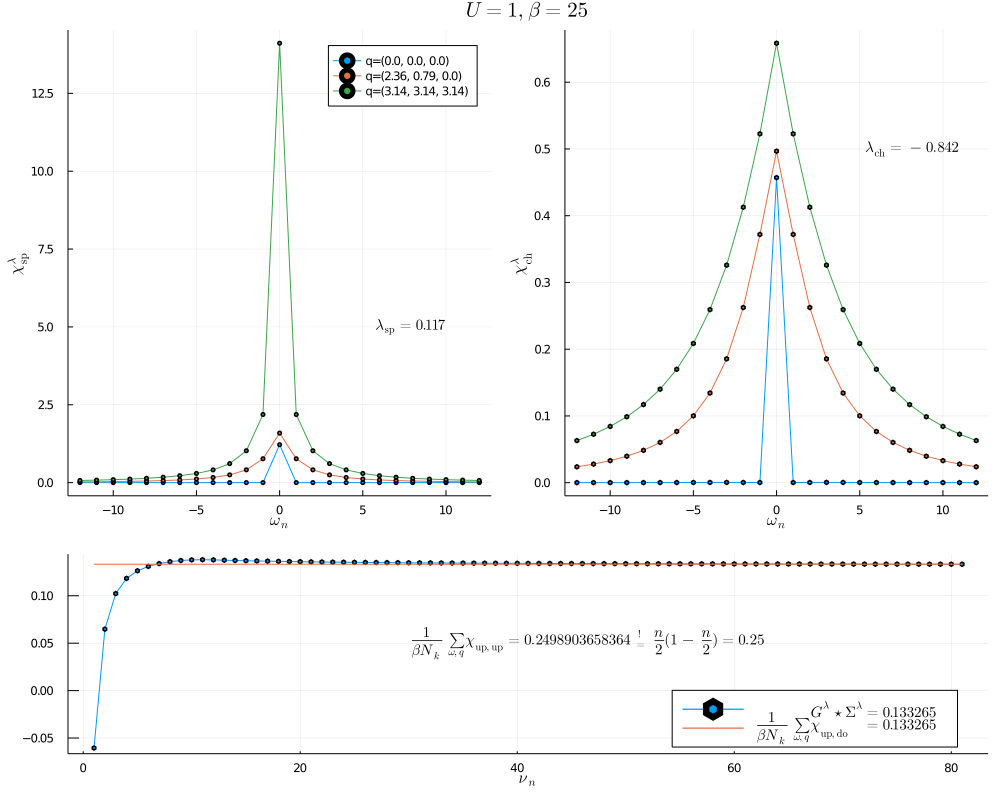

In [31]:
l = @layout [A{0.01h}; 
             [grid(1,2)
              b{0.3h}]]

xarr = usable_ω .- 81
title = plot(title = L"U=1, \beta=25", grid = false, showaxis = false, bottom_margin = -50Plots.px)
p1 = plot(xarr, χsp_λ[:,1], legend = true, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{sp}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:circle, markersize=2)
annotate!(10.0, 5, text(L"\lambda_\mathrm{sp} = %$(round(res.zero[1],digits=3))", :right, 10))
plot!(xarr, χsp_λ[:,60], label="q=$(round.(LadderDGA.qGrid[60],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, χsp_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:circle, markersize=2)

p2 = plot(xarr, χch_λ[:,1], legend = false, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{ch}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:hexagon, markersize=2)
annotate!(11.0, 0.5, text(L"\lambda_\mathrm{ch} = %$(round(res.zero[2],digits=3))", :right, 10))
plot!(xarr, χch_λ[:,60], label="q=$(round.(LadderDGA.qGrid[60],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, χch_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:hexagon, markersize=2)

p3 = plot(E_Pot, xlabel=L"\nu_n", label=L"\qquad\qquad\;\;\; G^\lambda \star \Sigma^\lambda = %$(round(E_Pot[end], digits=6))", markershape=:hexagon, markersize=2,legend=:bottomright, legendfontsize=10)
plot!(repeat([-rhs_c2], length(E_Pot)), label=L"\frac{1}{\beta N_k} \sum_{\omega,q} \chi_\mathrm{up, do}\quad\, = %$(round(-rhs_c2, digits=6))")
annotate!(30.0, 0.05, text(L"\frac{1}{\beta N_k}\sum_{\omega,q} \chi_\mathrm{up, up} = %$(round(rhs_c1 / 2,digits=14)) \stackrel{!}{=} \frac{n}{2} (1-\frac{n}{2}) = %$(mP.n/2 *(1 - mP.n/2))", :left, 10))

plot(title, p1, p2, p3, layout = l, size=(1000,800))
savefig("2cond_solution_.pdf")

In [390]:
include("src/ConvergenceAcc.jl")
Shanks.shanks(E_Pot, csum_inp=true) 

hit atol_denom


(0.1347886113822879, 24)

In [414]:
ωmin2 = 1#Int(floor(last(usable_ω .- sP.n_iω)*3/4))
ωmax2 = Int(last(usable_ω) - sP.n_iω) - 1
Wω_1 = LadderDGA.build_weights(ωmin2, ωmax2, [0,1,2,3])
Wω_2 = LadderDGA.build_weights(ωmin2, ωmax2, [0,1,2,3,4])
Wω_3 = LadderDGA.build_weights(ωmin2, ωmax2, [0,1,2,3,4,5])
Wω_4 = LadderDGA.build_weights(ωmin2, ωmax2, [0,2,4,6])
χupdo_naive = mP.U .* (χupdo[13] + 2 * sum(χupdo[14:end])) ./ mP.β
χupdo_shanks = mP.U .* (χupdo[13] + 2 * Shanks.shanks(χupdo[14:end])[1]) ./ mP.β
χupdo_richardson = mP.U .* (χupdo[13] + 2 * Float64(Shanks.richardson(χupdo[14:end])[end-1])) ./ mP.β
χupdo_GFFit_1 = mP.U * (real(LadderDGA.sum_freq(χupdo, [1], true, mP.β, weights=Wω_1)[1]))
χupdo_GFFit_2 = mP.U * (real(LadderDGA.sum_freq(χupdo, [1], true, mP.β, weights=Wω_2)[1]))
χupdo_GFFit_3 = mP.U * (real(LadderDGA.sum_freq(χupdo, [1], true, mP.β, weights=Wω_3)[1]))
χupdo_GFFit_4 = mP.U * (real(LadderDGA.sum_freq(χupdo, [1], true, mP.β, weights=Wω_4)[1]))

println("""Naive = $χupdo_naive
Shanks = $χupdo_shanks
Richardson = $χupdo_richardson
GFFit(1:12,0:3) = $(χupdo_GFFit_1)
GFFit(1:12,0:4) = $(χupdo_GFFit_2)
GFFit(1:12,0:5) = $(χupdo_GFFit_3)
GFFit(1:12,[0,2,4,6]) = $(χupdo_GFFit_4)""")

Naive = -0.13491564533599373
Shanks = -0.13536593874628322
Richardson = -0.1350100865612612
GFFit(1:12,0:3) = -0.13714815359721577
GFFit(1:12,0:4) = -0.13525023028434366
GFFit(1:12,0:5) = -0.1347350940001175
GFFit(1:12,[0,2,4,6]) = -0.13580764633303455
